In [24]:
import ee
import geemap
from datetime import datetime as dt
from datetime import date
from pprint import pprint

In [25]:
ee.Initialize()

### Subset EU country boundaries

In [26]:
world = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
# subset EU # how to combine them in one call?
eu = world.filter(ee.Filter.eq('wld_rgn', 'Europe'))
eu = eu.filter(ee.Filter.eq('country_na', 'Russia').Not())
eu = eu.filter(ee.Filter.eq('country_na', 'Svalbard').Not())
cyp = world.filter(ee.Filter.eq('country_na', 'Cyprus'))

eu = ee.FeatureCollection(eu.merge(cyp))

### Get SMAP collection

In [27]:
start_date = '2015-04-01'
end_date = date.today().strftime('%Y-%m-%d')

# subsurface soil moisture # 10km res - 2 or 3 days rev
susm = ee.ImageCollection("NASA_USDA/HSL/SMAP10KM_soil_moisture")\
    .select("susm")\
    .filterDate(start_date, end_date)

susm_vparams = {
    "min": 0.0,
    "max": 274.6,
    "palette": ['ff0303', 'efff07', 'efff07', '418504', '0300ff']
}

### Explore SMAP collection

In [28]:
# Get number of images
size = susm.size()

# Gate date range
rango = susm.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])

init_date = ee.Date(rango.get('min')).getInfo()['value']/1000.
init_date_f = dt.utcfromtimestamp(init_date).strftime('%Y-%m-%d %H:%M:%S')

last_date = ee.Date(rango.get('max')).getInfo()['value']/1000.
last_date_f = dt.utcfromtimestamp(last_date).strftime('%Y-%m-%d %H:%M:%S')

print('N images in SMAP collection:', size.getInfo(), '\nDate range SMAP: ', init_date_f, ' - ', last_date_f) 

N images in SMAP collection: 739 
Date range SMAP:  2015-04-02 12:00:00  -  2021-04-24 12:00:00


### Extract data for time series analysis

In [30]:
# test on single image
susm1 = susm.first()
meanReg = susm1.reduceRegions(
    reducer=ee.Reducer.mean(), 
    collection=eu, 
    scale=10000)

print('Object type:', meanReg.name(), '\nProperties')
pprint(meanReg.limit(1).getInfo()['features'][0]['properties'])

Object type: FeatureCollection 
Properties
{'abbreviati': 'Ukr.',
 'country_co': 'UP',
 'country_na': 'Ukraine',
 'mean': 105.05070243393943,
 'wld_rgn': 'Europe'}


In [31]:
# map function over ImageCollection
def regMean(image):
    return image.reduceRegions(
        reducer=ee.Reducer.mean(),
        collection=eu,
        scale=10000)

susm_mean = susm.map(regMean)
print('Object type:', susm_mean.name())

Object type: ImageCollection


In [32]:
susm_mean.propertyNames().getInfo()

['date_range',
 'period',
 'type_name',
 'max_mirrored_version',
 'thumb',
 'description',
 'source_tags',
 'system:id',
 'visualization_0_max',
 'provider_url',
 'title',
 'sample',
 'tags',
 'product_tags',
 'visualization_0_palette',
 'provider',
 'visualization_0_min',
 'system:version',
 'visualization_0_name',
 'visualization_0_bands']

In [33]:
susm_m1 = susm_mean.first()
print('Object type:', susm_m1.name())

Object type: Image


In [34]:
susm_m1.propertyNames().getInfo()

['system:index']

### Initialize map centered on EU

In [36]:
# initialize map
center_map = [48, 8]
zoom_default = 3
map0 = geemap.Map(center=center_map, zoom=zoom_default)
# add basemap
# map0.add_basemap("CartoDB.DarkMatter")
# add country borders
map0.addLayer(eu, {}, "National boundaries")
# add test on single image
map0.addLayer(meanReg, {}, 'Average SMAP Img1 EU countries')
map0

Map(center=[48, 8], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [37]:
map0.addLayer(susm_m1, {}, 'Test average mapped over collection')

EEException: Expression does not evaluate to an image.

### Define space units for time series analysis

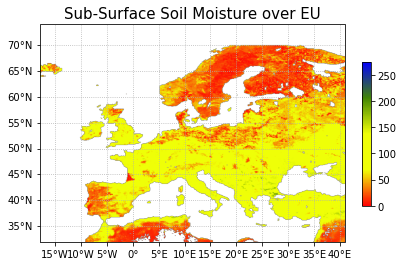

In [24]:
# xmin, ymin, xmax, ymax 
eu_bbox = [-18, 32, 41, 74]

susm1 = susm.first()
# Check grid size for spatial re-sampling
ax = cartoee.get_map(susm1, region=eu_bbox, vis_params=susm_vparams)
# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[5, 5], linestyle=":")
# add colorbar
cartoee.add_colorbar(ax, susm_vparams, loc='right')
# set title
ax.set_title(label='Sub-Surface Soil Moisture over EU', fontsize=15)
plt.show()